In [168]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import probplot
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm, probplot, skew
import numpy as np
from sklearn import preprocessing

In [169]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [170]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data


,Total,Percent
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
smoking_history,0,0.0
bmi,0,0.0
HbA1c_level,0,0.0
blood_glucose_level,0,0.0
diabetes,0,0.0


As we can see based off of the fact that we have no null values for any of our columns we do not need to apply any sort of handling of our missing data. In this case if we were to have missing data for age, bmi, HbA1c_level, blood_glucose_level we would take the medium values inside of these columns and input that for the missing values as this is best practice in our case. However just because there is no null values, the smoking history column has a section that says no info

In [171]:
count = (df['smoking_history'] == 'No Info').sum()
print(count)

print(df['smoking_history'].value_counts())
print("Total people with diabetes", df['diabetes'].sum())


diabetes = ((df['diabetes'] == 1) & (df['smoking_history'] == 'No Info')).sum()
diabetes2 = ((df['diabetes'] == 0) & (df['smoking_history'] == 'No Info')).sum()
print(f"Number of 'No info' on smoking histroy with Diabetes: {diabetes}")
print(f"Number of 'No info' on smoking histroy without Diabetes: {diabetes2}")

35816
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64
Total people with diabetes 8500
Number of 'No info' on smoking histroy with Diabetes: 1454
Number of 'No info' on smoking histroy without Diabetes: 34362


In [172]:
rows = len(df)

drop_percent = count/rows
drop_percent

0.35816

As can be seen by the 2 previous cells, the number of people that have diabetes with no info on their smoking history is about 17 percent of our total population of those that have diabetes. This brings into question what we should do with this column that has no info. 

<function matplotlib.pyplot.show(close=None, block=None)>

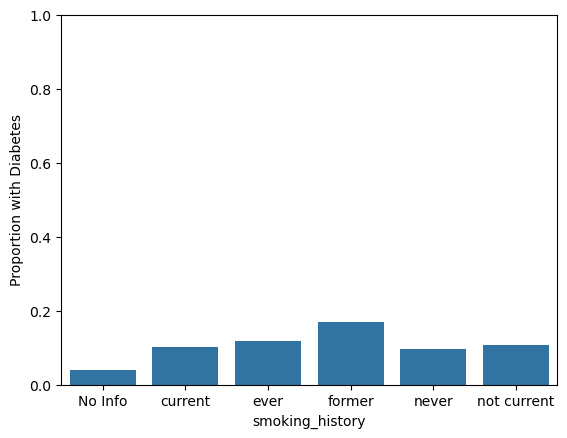

In [173]:
grouped = df.groupby('smoking_history')['diabetes'].mean().reset_index()

sns.barplot(x='smoking_history', y='diabetes', data=grouped)
plt.ylabel('Proportion with Diabetes')
plt.ylim(0,1)
plt.show

The graph shows the perentages of people with diabetes in correaltion to smoking history. As you can see 0 (no info) is far and away the lowest percentage of people with diabetes, but make up almost half our dataset. It makes sense to drop those rows and focus on the variables that effect our model in determining if a person has diabetes. 

In [174]:
df.drop(df[df['smoking_history'] == 'No Info'].index, inplace=True)
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
...,...,...,...,...,...,...,...,...,...
99992,Female,26.0,0,0,never,34.34,6.5,160,0
99993,Female,40.0,0,0,never,40.69,3.5,155,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [175]:
print("Number of 'No info' for smokers: ", (df['smoking_history'] == "No Info").sum())

Number of 'No info' for smokers:  0


Here we can create a label encoder to encode all of our categorical data. This will correspond to never smoking = 4, former smoker = 3, not current smoker = 2, current smoker = 1, no info = 0

In [176]:
le = LabelEncoder()
df["smoking_encoded"] = le.fit_transform(df["smoking_history"])
encoded = le.fit_transform(df['smoking_encoded'])
df.head(15)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,Female,80.0,0,1,never,25.19,6.6,140,0,3
2,Male,28.0,0,0,never,27.32,5.7,158,0,3
3,Female,36.0,0,0,current,23.45,5.0,155,0,0
4,Male,76.0,1,1,current,20.14,4.8,155,0,0
5,Female,20.0,0,0,never,27.32,6.6,85,0,3
6,Female,44.0,0,0,never,19.31,6.5,200,1,3
8,Male,42.0,0,0,never,33.64,4.8,145,0,3
9,Female,32.0,0,0,never,27.32,5.0,100,0,3
10,Female,53.0,0,0,never,27.32,6.1,85,0,3
11,Female,54.0,0,0,former,54.70,6.0,100,0,2


We can also get rid of the gender category and dummy encode it, knowing that if we have 

In [177]:
df = pd.get_dummies(df, columns=["gender"], drop_first=True)
df.drop(columns=["gender_Other"], inplace=True)
df

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,3,False
2,28.0,0,0,never,27.32,5.7,158,0,3,True
3,36.0,0,0,current,23.45,5.0,155,0,0,False
4,76.0,1,1,current,20.14,4.8,155,0,0,True
5,20.0,0,0,never,27.32,6.6,85,0,3,False
...,...,...,...,...,...,...,...,...,...,...
99992,26.0,0,0,never,34.34,6.5,160,0,3,False
99993,40.0,0,0,never,40.69,3.5,155,0,3,False
99997,66.0,0,0,former,27.83,5.7,155,0,2,True
99998,24.0,0,0,never,35.42,4.0,100,0,3,False


The cell below demonstrates the lack of homogeniouty between our different categorical elements, with smoking_history having a ~.546 mode frequency, showing this could be a viable comparison for our model.

In [178]:
print("Categorical Columns Mode Frequency")
cat_columns = df.select_dtypes(include=["object"]).columns
mode_freq_df = pd.DataFrame(columns=["column_name", "mode_frequency"])
mode_freq_df.head
for col in cat_columns:
    mode_value = df[col].mode().iat[0]
    mode_freq = (df[col] == mode_value).mean()
# create a new row at the next integer index
mode_freq_df.loc[len(mode_freq_df)] = [col, mode_freq]
print(mode_freq_df.sort_values("mode_frequency", ascending=False).head(10))

Categorical Columns Mode Frequency
       column_name  mode_frequency
0  smoking_history        0.546787


---
Handling Outliers

In [179]:
df.head()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,3,False
2,28.0,0,0,never,27.32,5.7,158,0,3,True
3,36.0,0,0,current,23.45,5.0,155,0,0,False
4,76.0,1,1,current,20.14,4.8,155,0,0,True
5,20.0,0,0,never,27.32,6.6,85,0,3,False


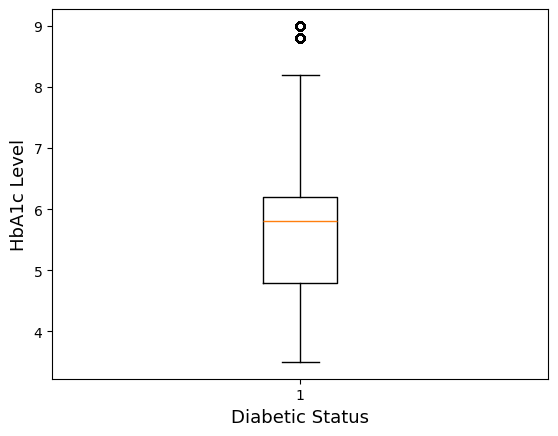

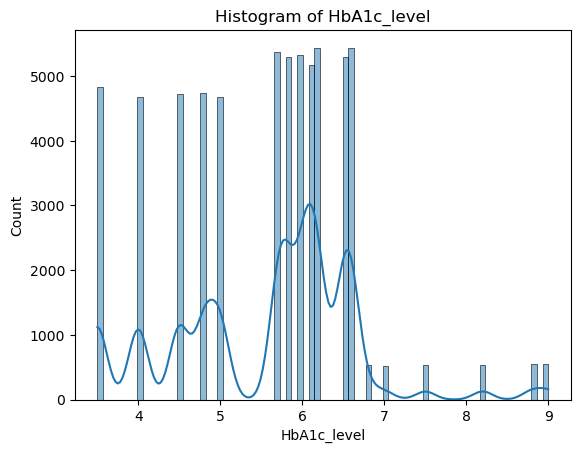

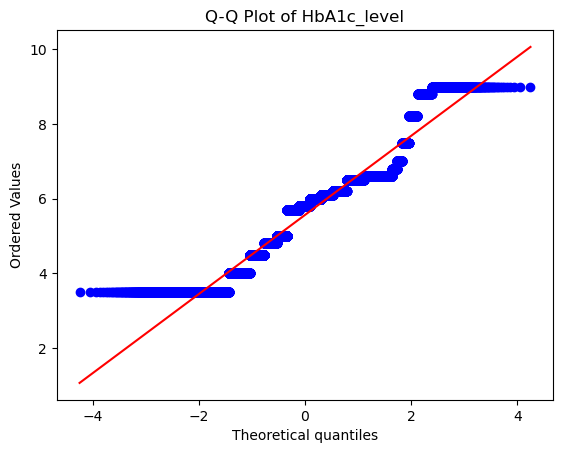

In [180]:
fig, ax = plt.subplots()
ax.boxplot(x=df["HbA1c_level"])
plt.ylabel("HbA1c Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["HbA1c_level"], kde=True)
plt.title(f'Histogram of HbA1c_level')
plt.show()
probplot(df["HbA1c_level"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of HbA1c_level')
plt.show()

As this data does have some outliers we are not going to get rid of those as they may be clinically significant. Through research we found that high HbA1c is often associated with diabetes, so we do not want to to get rid of this and lose accuracy of our model. However we will need to preform normalization techniques on the series as shown by the histrogram the data is no where near normal. This can also be seen by the qq plot as our data does not stick to the red line. We will need to preform these normalization techniques to ensure that we can use logistic regression to its most potential, as this is a requirement for logistic regression to work accuratly. 



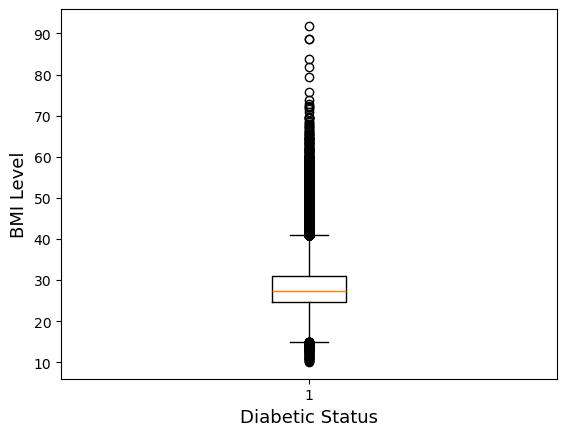

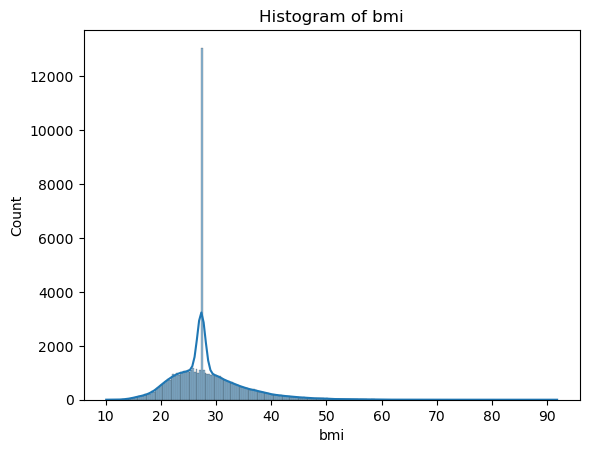

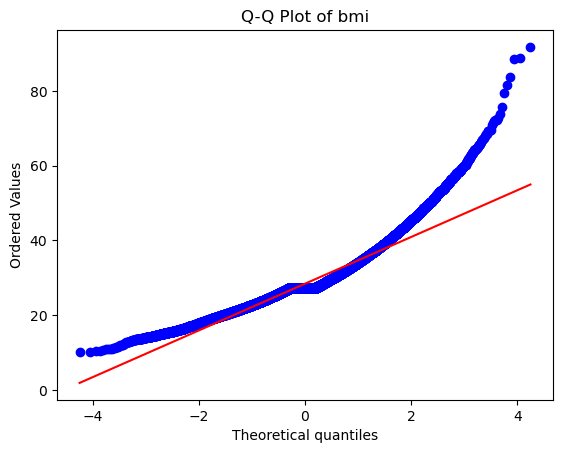

In [181]:
fig, ax = plt.subplots()
ax.boxplot(x=df["bmi"])
plt.ylabel("BMI Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["bmi"], kde=True)
plt.title(f'Histogram of bmi')
plt.show()
probplot(df["bmi"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of bmi')
plt.show()

As can be seen by this graph there are a lot of outliers. We do not want to get rid of this data as these are likely valid and meaningful, especially in a medical context. Removing them would reduce the model's ability to identify high risk individuals. As seen by the histogram normalization will need to be preformed on this series as to complete logistic regression the data must be normal. We can also see how our data is unormal through the qq plot of BMI as it is not fully along the red line, especially at the end where it starts to curve up which signifies heavy outliers. 

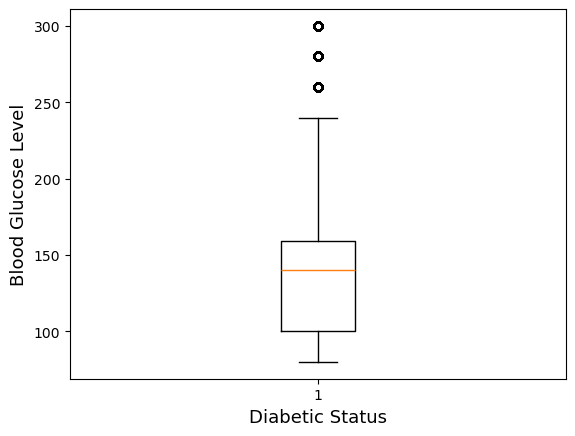

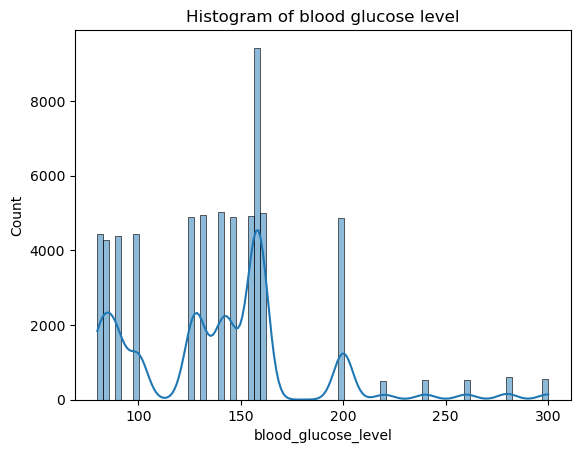

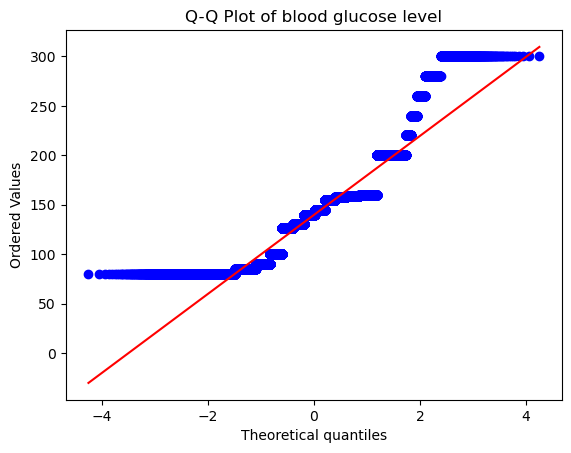

In [182]:

fig, ax = plt.subplots()
ax.boxplot(x=df["blood_glucose_level"])
plt.ylabel("Blood Glucose Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["blood_glucose_level"], kde=True)
plt.title(f'Histogram of blood glucose level')
plt.show()
probplot(df["blood_glucose_level"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of blood glucose level')
plt.show()

As blood gluscose level does have some outliers we are not going to get rid of those as higher blood glucose levels could lead to a higher chance of diabetes. However as can be obsereved by the histogram of blood glucose level, the sereis is no where near normal, so we will have to normalize this series as well in order to complete logisitc regression, The qq plot also gives a more understandable graph to show how far our data is from being normal as it rarely is toucing the red line that indicats a normal distribution. 

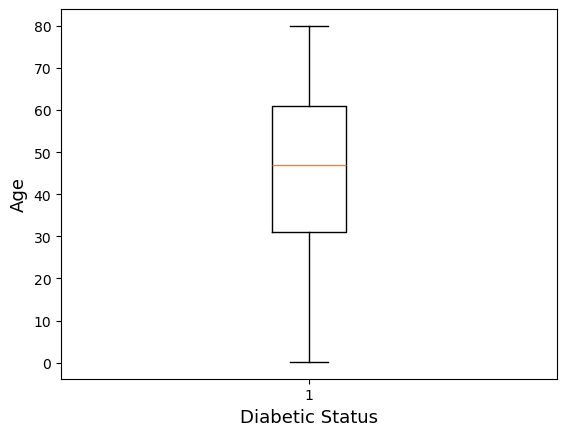

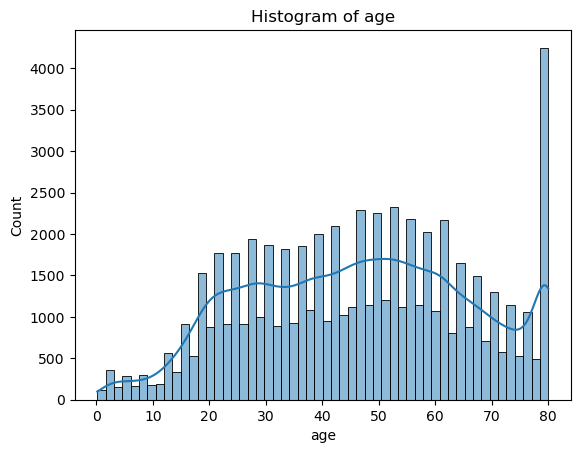

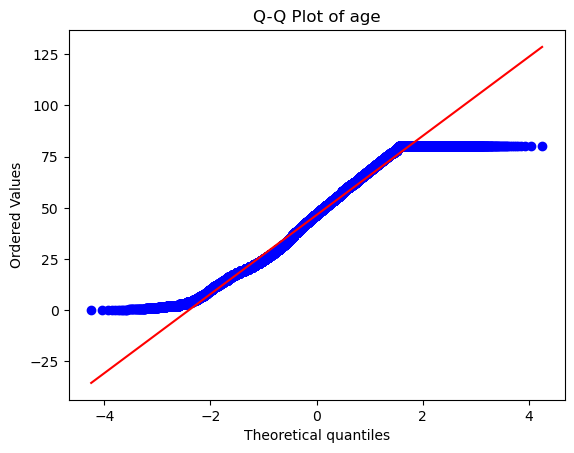

In [183]:
fig, ax = plt.subplots()
ax.boxplot(x=df["age"])
plt.ylabel("Age", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["age"], kde=True)
plt.title(f'Histogram of age')
plt.show()
probplot(df["age"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of age')
plt.show()

As can be seen by the boxplot this series does not have any outliers, and this is propably the most normal data that we have seen so far. However we will still apply normalization techniques to this series to ensure that logisitic regression works as best as possible. 

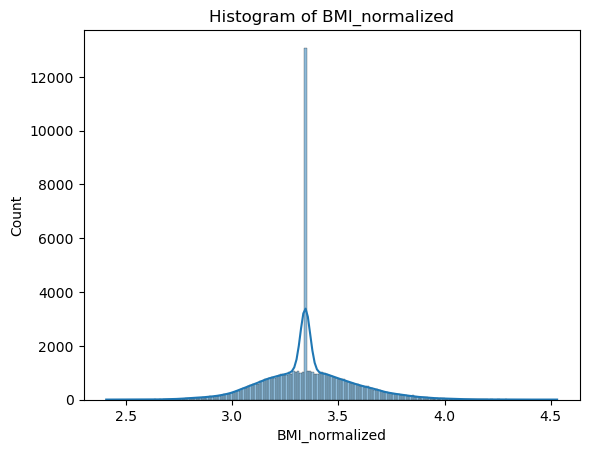

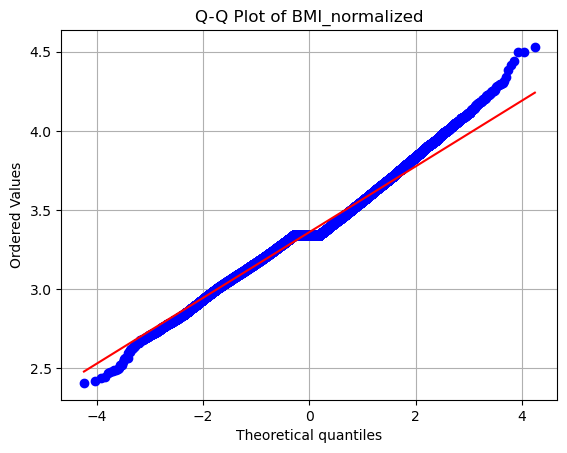

In [184]:
num_cols = ['age', 'HbA1c_level', 'blood_glucose_level']
# x_array = df[num_cols].values  # shape (n_samples, n_features)
# # Normalize column-wise (axis=0 ensures each column is normalized independently)
# normalized_arr = preprocessing.normalize(x_array, axis=0)

# # Assign back to DataFrame (overwrite original columns)
# df[num_cols] = pd.DataFrame(normalized_arr, columns=num_cols)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df["BMI_normalized"] = np.log1p(df["bmi"])
sns.histplot(df["BMI_normalized"], kde=True)
plt.title(f'Histogram of BMI_normalized')
plt.show()

plt.figure()

probplot(df["BMI_normalized"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of BMI_normalized')
plt.grid(True)

plt.show()

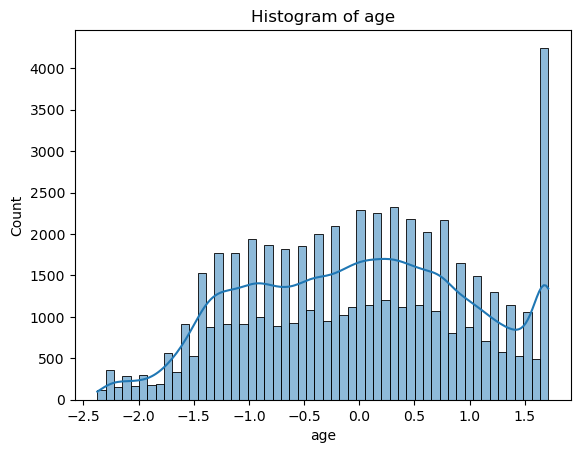

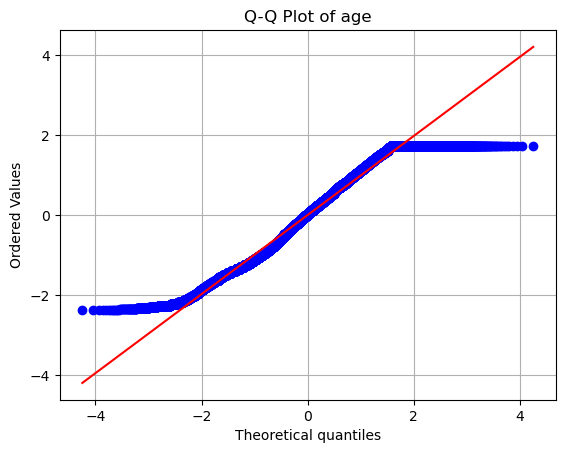

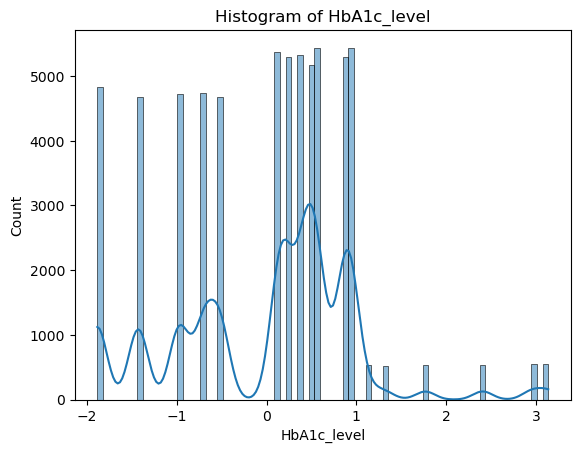

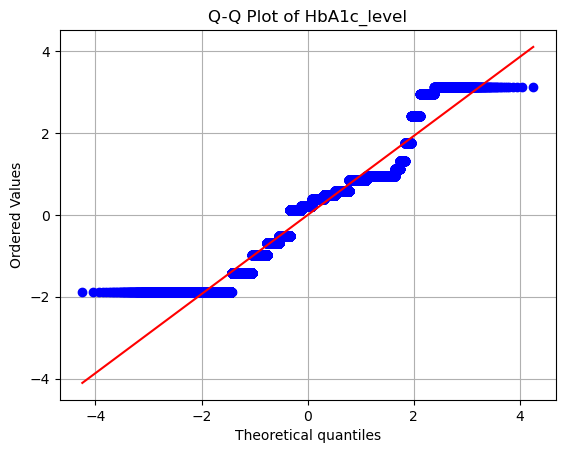

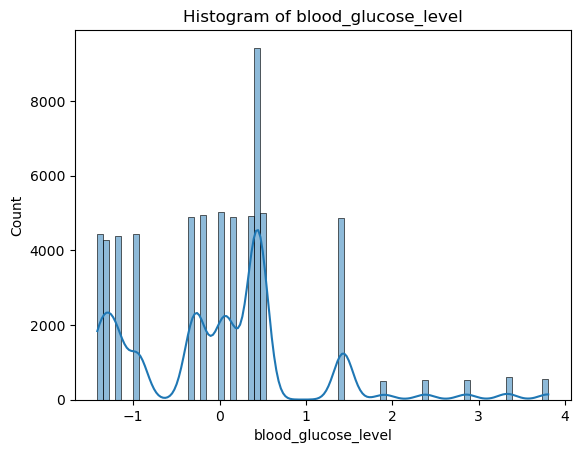

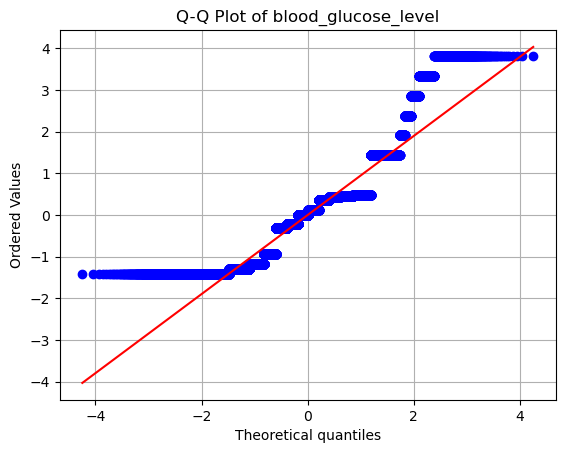

In [185]:
for col in num_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()
    
    plt.figure()

    probplot(df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')
    plt.grid(True)

    plt.show()

In [187]:
# Identify variable types
categorical_vars = ['gender_Male', 'smoking_history']
ordinal_vars = ['hypertension', 'heart_disease']
numerical_vars = ['age', 'BMI_normalized', 'HbA1c_level', 'blood_glucose_level']
target_var = 'diabetes'

print("Categorical Variables:", categorical_vars)
print("Ordinal Variables:", ordinal_vars)
print("Numerical Variables:", numerical_vars)
print("Target Variable (Dependent):", target_var)

Categorical Variables: ['gender_Male', 'smoking_history']
Ordinal Variables: ['hypertension', 'heart_disease']
Numerical Variables: ['age', 'BMI_normalized', 'HbA1c_level', 'blood_glucose_level']
Target Variable (Dependent): diabetes


While we have encoded the variables gender and smoking_history, they are still categorical variables but we will just represent them with numbers.

In [188]:
# Measures of centrality and distribution
df[numerical_vars].describe()

,age,BMI_normalized,HbA1c_level,blood_glucose_level
count,6.418400e+04,64184.000000,6.418400e+04,6.418400e+04
mean,-2.811882e-16,3.359231,-2.851736e-16,1.000764e-16
std,1.000008e+00,0.210112,1.000008e+00,1.000008e+00
min,-2.373781e+00,2.405142,-1.884309e+00,-1.414145e+00
25%,-7.954947e-01,3.242592,-6.976479e-01,-9.398241e-01
50%,2.333080e-02,3.343568,2.151683e-01,8.817024e-03
75%,7.398031e-01,3.468856,5.802948e-01,4.594216e-01
max,1.712158e+00,4.530662,3.136180e+00,3.803382e+00


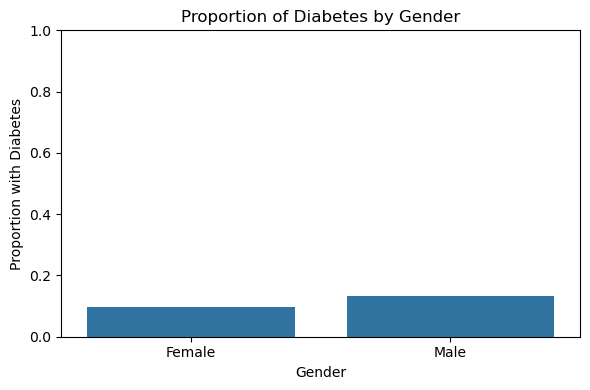

In [190]:
# print(df)
# for col in categorical_vars:
#     plt.figure(figsize=(6, 4))
#     sns.countplot(x=col, hue=target_var, data=df)
#     plt.title(f'Diabetes Distribution across {col}')
#     plt.tight_layout()
#     plt.show()
# Compute diabetes rate within each gender group
gender_diabetes_rate = df.groupby('gender_Male')['diabetes'].mean().reset_index()

# Plot as bar plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x='gender_Male', y='diabetes', data=gender_diabetes_rate)
plt.title('Proportion of Diabetes by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.xticks([0, 1], ['Female', 'Male'])  # Better labels
plt.tight_layout()
plt.show()

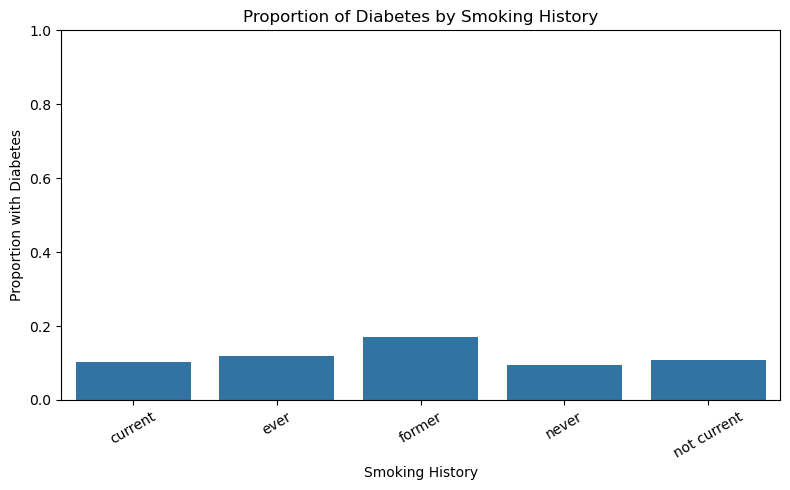

In [191]:
# Calculate proportion of diabetes in each smoking category
smoking_diabetes_rate = df.groupby('smoking_history')['diabetes'].mean().reset_index()

# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(x='smoking_history', y='diabetes', data=smoking_diabetes_rate)
plt.title('Proportion of Diabetes by Smoking History')
plt.xlabel('Smoking History')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

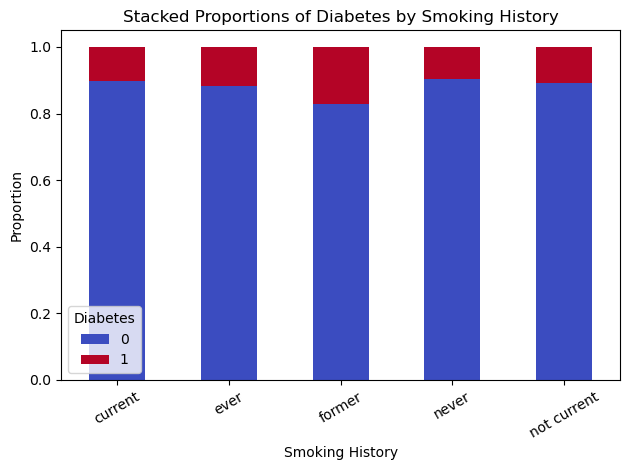

In [192]:
smoking_crosstab = pd.crosstab(df['smoking_history'], df['diabetes'], normalize='index')
smoking_crosstab.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Stacked Proportions of Diabetes by Smoking History')
plt.ylabel('Proportion')
plt.xlabel('Smoking History')
plt.legend(title='Diabetes')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

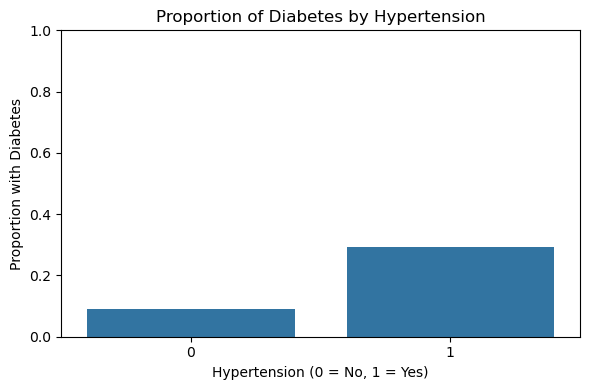

In [193]:
# Proportion of diabetes within hypertension groups
htn_rate = df.groupby('hypertension')['diabetes'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='hypertension', y='diabetes', data=htn_rate)
plt.title('Proportion of Diabetes by Hypertension')
plt.xlabel('Hypertension (0 = No, 1 = Yes)')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

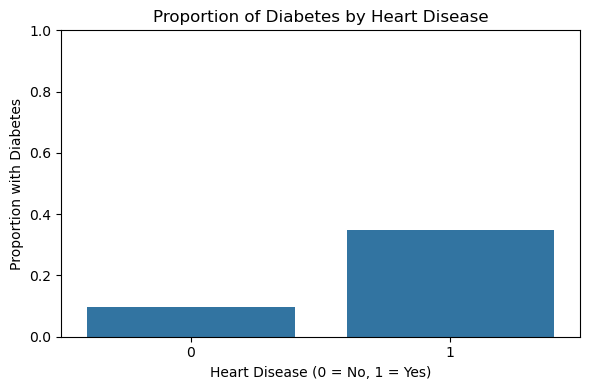

In [194]:
heart_rate = df.groupby('heart_disease')['diabetes'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='heart_disease', y='diabetes', data=heart_rate)
plt.title('Proportion of Diabetes by Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

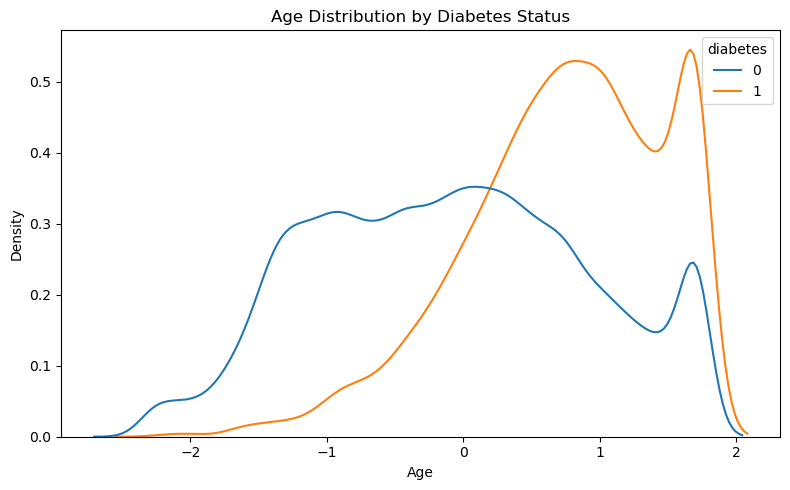

In [195]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='age', hue='diabetes', common_norm=False)
plt.title('Age Distribution by Diabetes Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

This graph shows how age is positively correlated with diabetes. The diabetic population tends to be older, while younger individuals are more likely to be non-diabetic. This pattern supports our research that the risk of developing diabetes increases with age.

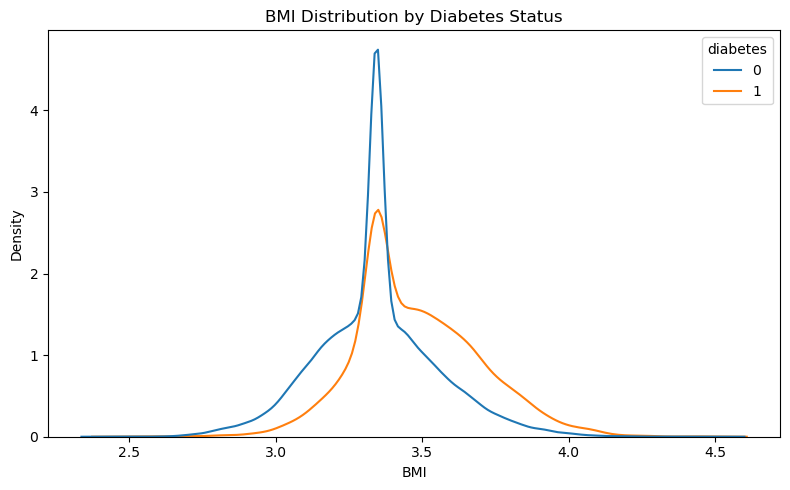

In [196]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='BMI_normalized', hue='diabetes', common_norm=False)
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

While both groups share similar median BMI values, individuals with diabetes exhibit more variance and a slight shift toward higher BMI values. This suggests a potential, though not dominant, relationship between higher BMI and diabetes risk.

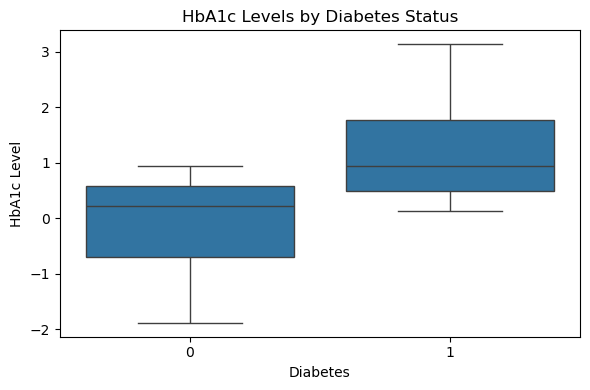

In [197]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c Levels by Diabetes Status')
plt.xlabel('Diabetes')
plt.ylabel('HbA1c Level')
plt.tight_layout()
plt.show()


There is a strong positive association between elevated HbA1c levels and diabetes. Individuals diagnosed with diabetes tend to have significantly higher HbA1c levels, which aligns with research that we have done about HbA1c levels and diabetes. This makes it a reliable indicator for distinguishing diabetic status.

# I asked chat to make this and I do not really know what it means but feel free to describe it

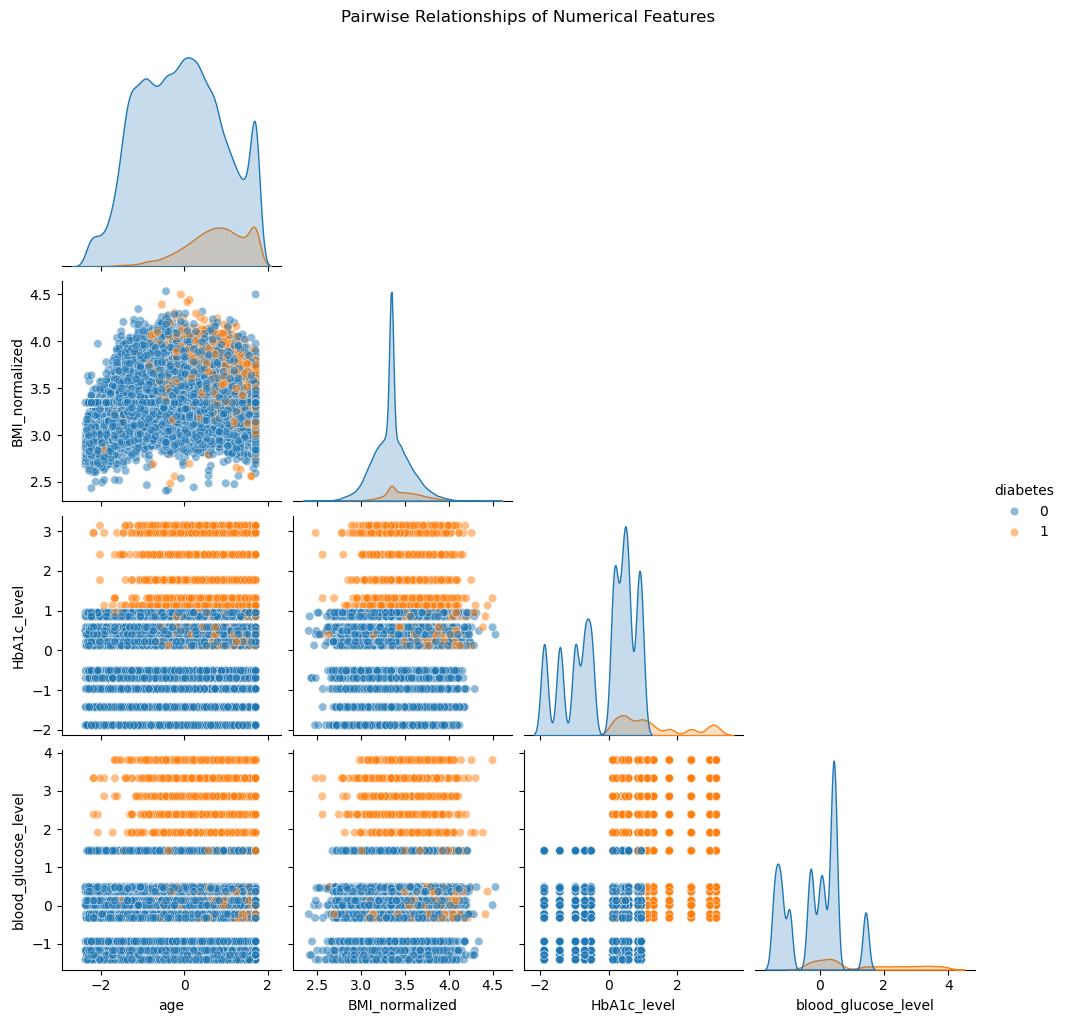

In [198]:
sns.pairplot(df, vars=['age', 'BMI_normalized', 'HbA1c_level', 'blood_glucose_level'], hue='diabetes', corner=True, plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Relationships of Numerical Features', y=1.02)
plt.show()

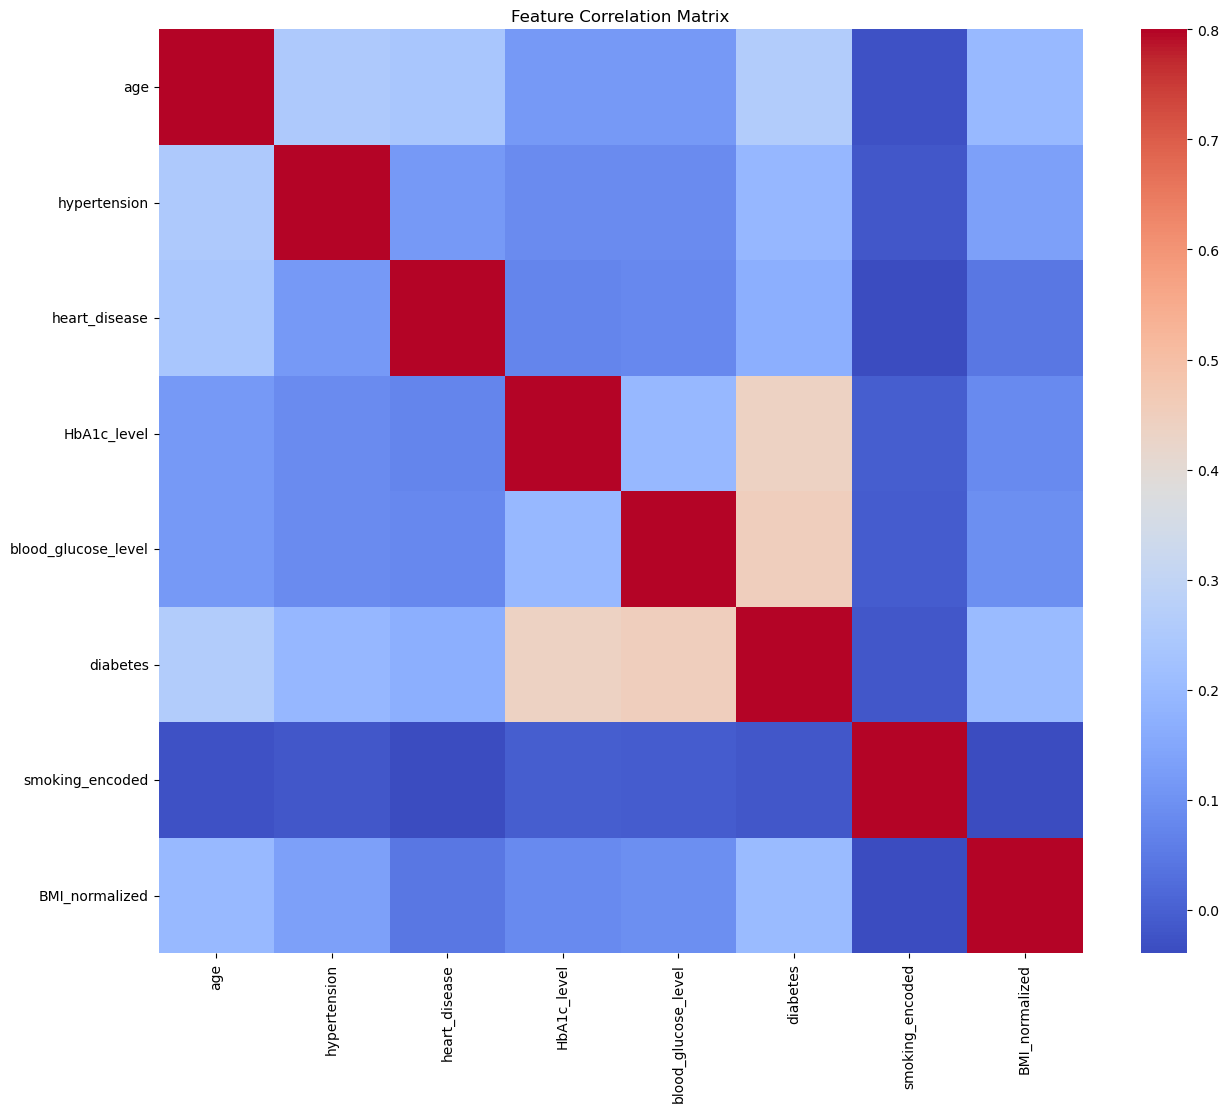

In [186]:
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Feature Correlation')
# plt.show()
# df.head(10)
df = df.drop(columns=['bmi'])
numeric_df = df.select_dtypes(include=[np.number])
corrmat = numeric_df.corr()
# Plot
plt.figure(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

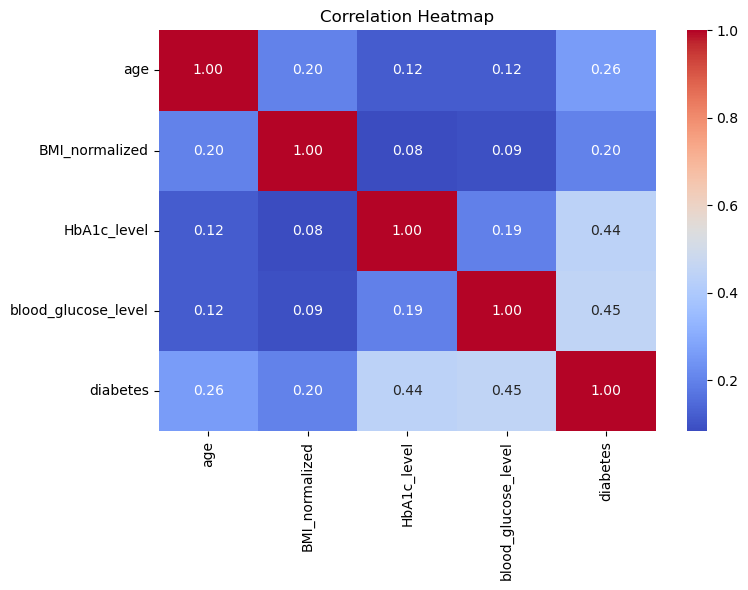

In [189]:
corr_matrix = df[numerical_vars + [target_var]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()